# 載入`Accelerate`套件

* 用來取代PyTouch的`torch`套件，以加速運算，設定多GPU，多節點運算等功能。
* 在大型模型時代，每個人都在想辦法用最少的VRAM來訓練模型，或是用最適量的VRAM來訓練更大的模型。
* 單卡的VRAM有上限，因此用多卡，多台是一個解決方案。

https://huggingface.co/docs/accelerate/main/en/index

In [1]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

# 資料集介紹

* 主要功能就是將Video Game的NLP轉換成特定格式
* 用來做大型模型的SFT


https://huggingface.co/datasets/GEM/viggo?row=0

In [2]:
from datasets import load_dataset

train_dataset = load_dataset('gem/viggo', split='train')
eval_dataset = load_dataset('gem/viggo', split='validation')
test_dataset = load_dataset('gem/viggo', split='test')

In [3]:
print(train_dataset)
print(eval_dataset)
print(test_dataset)

Dataset({
    features: ['gem_id', 'meaning_representation', 'target', 'references'],
    num_rows: 5103
})
Dataset({
    features: ['gem_id', 'meaning_representation', 'target', 'references'],
    num_rows: 714
})
Dataset({
    features: ['gem_id', 'meaning_representation', 'target', 'references'],
    num_rows: 1083
})


# 載入基礎模型
* 載入基礎模型，並且設定好`tokenizer`，`model`，`data_collator`，`metric`等等。
* 這邊使用`AutoModelForCaualLM`，`AutoTokenizer`，因為是生成式任務
* 設定量化的的參數，並且使用4bit的量化，可以將資料從32bit壓縮到4bit，這樣可以減少模型的大小，加速運算。
* 如果GPU的VRAM不夠，可以將部分權重移至CPU來減少模型的大小，但是會影響模型的速度。

In [5]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,    
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, 
                                             quantization_config=bnb_config, 
                                             low_cpu_mem_usage=True,)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

# 設定tokenizer
* 以基礎模型預訓練方式載入
* 設定`max_length`，`padding`，`truncation`等等參數
* 把padding token設定到左邊，例如：I love you -> [PAD] [PAD] [PAD] I love you
* 如果是padding設定到右邊，例如：I love you -> I love you [PAD] [PAD] [PAD]
* 生成式任務，會把input也當作output再放入next token。如果放右邊，就會在原句和生成的token之間有padding token，這樣會影響模型的訓練。
* eos = pad，表示當pad在右邊時，就要結束了

In [6]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    model_max_length=512,
    padding_side="left",
    add_eos_token=True)

tokenizer.pad_token = tokenizer.eos_token

# CLM模型必須將input和label設定成一樣
* 在訓練時，模型內部會自動shift
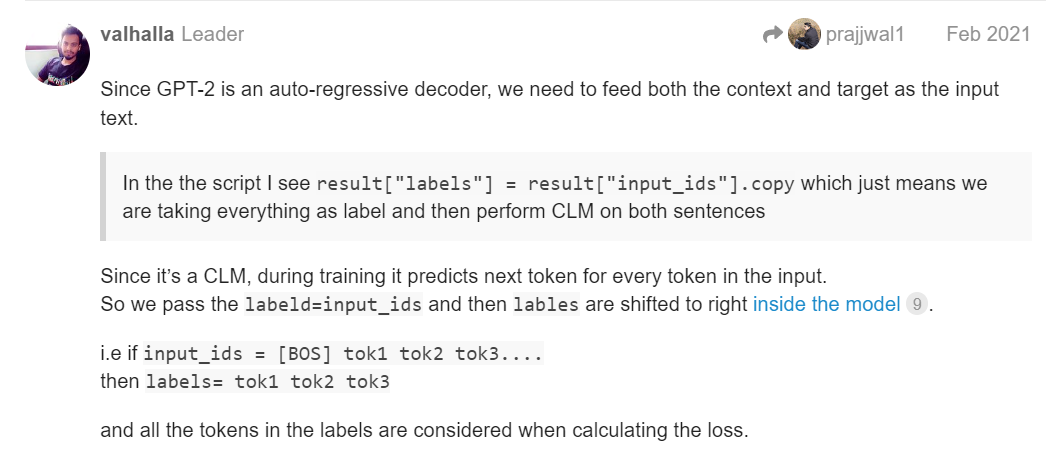

說明在這邊
https://discuss.huggingface.co/t/what-is-the-context-as-per-run-clm/3425/5

In [7]:
def tokenize(prompt):
    result = tokenizer(
        prompt,
        truncation=True,
        max_length=512,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [8]:
def generate_and_tokenize_prompt(data_point):
    full_prompt =f"""Given a target sentence construct the underlying meaning representation of the input sentence as a single function with attributes and attribute values.
This function should describe the target string accurately and the function must be one of the following ['inform', 'request', 'give_opinion', 'confirm', 'verify_attribute', 'suggest', 'request_explanation', 'recommend', 'request_attribute'].
The attributes must be one of the following: ['name', 'exp_release_date', 'release_year', 'developer', 'esrb', 'rating', 'genres', 'player_perspective', 'has_multiplayer', 'platforms', 'available_on_steam', 'has_linux_release', 'has_mac_release', 'specifier']

### Target sentence:
{data_point["target"]}

### Meaning representation:
{data_point["meaning_representation"]}
"""
    return tokenize(full_prompt)

In [9]:
test_dataset[3]

{'gem_id': 'viggo-test-3',
 'meaning_representation': "inform(name[Tom Clancy's The Division], esrb[M (for Mature)], rating[average], genres[role-playing, shooter, tactical], player_perspective[third person], has_multiplayer[yes], platforms[PlayStation, Xbox, PC], available_on_steam[yes])",
 'target': "Tom Clancy's The Division was released with a M (for Mature) rating. It's an average role-playing, shooter, tactical third person game, that offers a multiplayer mode. It's available for PlayStation, Xbox, and PC, as well as for Steam.",
 'references': ["Tom Clancy's The Division was released with a M (for Mature) rating. It's an average role-playing, shooter, tactical third person game, that offers a multiplayer mode. It's available for PlayStation, Xbox, and PC, as well as for Steam."]}

In [10]:
generate_and_tokenize_prompt(test_dataset[3])

{'input_ids': [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 12628, 264, 2718, 12271, 5122, 272, 14164, 5746, 9283, 302, 272, 2787, 12271, 390, 264, 2692, 908, 395, 9623, 304, 6836, 3069, 28723, 13, 3260, 908, 1023, 6685, 272, 2718, 1423, 24329, 304, 272, 908, 1580, 347, 624, 302, 272, 2296, 5936, 262, 674, 647, 464, 3134, 647, 464, 28721, 495, 28730, 410, 262, 296, 647, 464, 19928, 647, 464, 14876, 28730, 9122, 647, 464, 28713, 16939, 647, 464, 3134, 28730, 720, 11009, 352,

# 準備好tokenized好的資料集

In [11]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)
tokenized_test_dataset = test_dataset.map(generate_and_tokenize_prompt)

In [12]:
print("Target Sentence: " + test_dataset[3]['target'])
print("Meaning Representation: " + test_dataset[3]['meaning_representation'] + "\n")

Target Sentence: Tom Clancy's The Division was released with a M (for Mature) rating. It's an average role-playing, shooter, tactical third person game, that offers a multiplayer mode. It's available for PlayStation, Xbox, and PC, as well as for Steam.
Meaning Representation: inform(name[Tom Clancy's The Division], esrb[M (for Mature)], rating[average], genres[role-playing, shooter, tactical], player_perspective[third person], has_multiplayer[yes], platforms[PlayStation, Xbox, PC], available_on_steam[yes])



In [13]:
eval_prompt = """Given a target sentence construct the underlying meaning representation of the input sentence as a single function with attributes and attribute values.
This function should describe the target string accurately and the function must be one of the following ['inform', 'request', 'give_opinion', 'confirm', 'verify_attribute', 'suggest', 'request_explanation', 'recommend', 'request_attribute'].
The attributes must be one of the following: ['name', 'exp_release_date', 'release_year', 'developer', 'esrb', 'rating', 'genres', 'player_perspective', 'has_multiplayer', 'platforms', 'available_on_steam', 'has_linux_release', 'has_mac_release', 'specifier']

### Target sentence:
Tom Clancy's The Division was released with a M (for Mature) rating. It's an average role-playing, shooter, tactical third person game, that offers a multiplayer mode. It's available for PlayStation, Xbox, and PC, as well as for Steam.

### Meaning representation:
"""

In [14]:
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

In [15]:
model.eval()

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )
   

In [16]:
with torch.no_grad():
    test_result = model.generate(**model_input, max_new_tokens=256, pad_token_id=2)

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


In [17]:
test_result[0]

tensor([    1, 12628,   264,  2718, 12271,  5122,   272, 14164,  5746,  9283,
          302,   272,  2787, 12271,   390,   264,  2692,   908,   395,  9623,
          304,  6836,  3069, 28723,    13,  3260,   908,  1023,  6685,   272,
         2718,  1423, 24329,   304,   272,   908,  1580,   347,   624,   302,
          272,  2296,  5936,   262,   674,   647,   464,  3134,   647,   464,
        28721,   495, 28730,   410,   262,   296,   647,   464, 19928,   647,
          464, 14876, 28730,  9122,   647,   464, 28713, 16939,   647,   464,
         3134, 28730,   720, 11009,   352,   647,   464,   267,  1805,   416,
          647,   464,  3134, 28730,  9122, 14303,    13,  1014,  9623,  1580,
          347,   624,   302,   272,  2296, 28747,  5936,   861,   647,   464,
         5128, 28730, 11023, 28730,  1408,   647,   464, 11023, 28730,  4395,
          647,   464, 16239,   263,   647,   464,   274,  9312,   647,   464,
        28599,   647,   464,  2383,   411,   647,   464,  7449, 

In [18]:
print(tokenizer.decode(a1[0], skip_special_tokens=True))

Given a target sentence construct the underlying meaning representation of the input sentence as a single function with attributes and attribute values.
This function should describe the target string accurately and the function must be one of the following ['inform', 'request', 'give_opinion', 'confirm', 'verify_attribute', 'suggest', 'request_explanation', 'recommend', 'request_attribute'].
The attributes must be one of the following: ['name', 'exp_release_date', 'release_year', 'developer', 'esrb', 'rating', 'genres', 'player_perspective', 'has_multiplayer', 'platforms', 'available_on_steam', 'has_linux_release', 'has_mac_release', 'specifier']

### Target sentence:
Tom Clancy's The Division was released with a M (for Mature) rating. It's an average role-playing, shooter, tactical third person game, that offers a multiplayer mode. It's available for PlayStation, Xbox, and PC, as well as for Steam.

### Meaning representation:
вери_атрибут(name, Tom Clancy's The Division)

### Explan

# 一些減少記憶體的方法
https://zhuanlan.zhihu.com/p/555283334

In [19]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

# 計算模型參數
* 這邊使用`model.num_parameters()`來計算模型的參數
* 計算需要梯度的參數，以及不需要梯度的參數
* 算出兩者的比例

In [20]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [ ]:
print(model)

# 設定LORA的值
* 設定矩陣的秩
* 設定哪些模型中的值需要被LORA提取
* 載入PEFT模型
* 使用Accelerate套件來加速運算

In [21]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

# Apply the accelerator. You can comment this out to remove the accelerator.
model = accelerator.prepare_model(model)

trainable params: 21260288 || all params: 3773331456 || trainable%: 0.5634354746703705


In [ ]:
print(model)

# 使用多GPU

In [22]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

# 設定模型
* 模型名稱存檔目錄
* 基礎模型名稱
* 輸出目錄名稱
* 設定特殊字元值如原模型


# 設定訓練參數
* learning rate的暖身次數
* 超參數，如batch size，learning rate，weight decay等等
* 梯度累積再更新的次數
* 如果是30系列以上的GPU才能使用`bf16`
* 優化器
* 設定data_collator

In [23]:
import transformers
from datetime import datetime

project = "viggo-finetune"
base_model_name = "mistral"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

tokenizer.pad_token = tokenizer.eos_token

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=5,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=4,
        max_steps=1000,
        learning_rate=2.5e-5, # Want about 10x smaller than the Mistral learning rate
        logging_steps=50,
        bf16=True,
        optim="paged_adamw_8bit",
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=50,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=50,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        # report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: josh-hu. Use `wandb login --relogin` to force relogin


/home/joshhu/miniconda3/envs/test/lib/python3.11/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
50,0.776000,0.271323
100,0.244100,0.217370
150,0.205200,0.188993
200,0.181500,0.178292
250,0.174900,0.172434
300,0.168400,0.168425
350,0.164600,0.166433
400,0.167200,0.164490
450,0.157000,0.162123
500,0.164400,0.160399


Checkpoint destination directory ./mistral-viggo-finetune/checkpoint-50 already exists and is non-empty. Saving will proceed but saved results may be invalid.
/home/joshhu/miniconda3/envs/test/lib/python3.11/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
Checkpoint destination directory ./mistral-viggo-finetune/checkpoint-100 already exists and is non-empty. Saving will proceed but saved results may be invalid.
/home/joshhu/miniconda3/envs/test/lib/python3.11/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The

TrainOutput(global_step=1000, training_loss=0.1928461947441101, metrics={'train_runtime': 8483.5421, 'train_samples_per_second': 0.943, 'train_steps_per_second': 0.118, 'total_flos': 1.7525216609776435e+17, 'train_loss': 0.1928461947441101, 'epoch': 1.57})

# 以上訓練完畢，以下為inference

In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, 
                                             quantization_config=bnb_config,
                                             low_cpu_mem_usage=True,)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [2]:
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
    # use_auth_token=True
)

tokenizer = AutoTokenizer.from_pretrained(base_model_id, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "mistral-viggo-finetune/checkpoint-1000")

In [8]:
PeftModel.save_pretrained(ft_model, "ft_model", push_to_hub=True, repo_name="viggo-peft-model")

In [5]:
eval_prompt = """Given a target sentence construct the underlying meaning representation of the input sentence as a single function with attributes and attribute values.
This function should describe the target string accurately and the function must be one of the following ['inform', 'request', 'give_opinion', 'confirm', 'verify_attribute', 'suggest', 'request_explanation', 'recommend', 'request_attribute'].
The attributes must be one of the following: ['name', 'exp_release_date', 'release_year', 'developer', 'esrb', 'rating', 'genres', 'player_perspective', 'has_multiplayer', 'platforms', 'available_on_steam', 'has_linux_release', 'has_mac_release', 'specifier']

### Target sentence:
這個賽車遊戲叫大賽車，可以多人玩，好玩，我可以Linux上和蘋果電腦上玩。

### Meaning representation:
"""

model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

In [6]:
ft_model.eval()
with torch.no_grad():
    print(tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100, pad_token_id=2)[0], skip_special_tokens=True))


Given a target sentence construct the underlying meaning representation of the input sentence as a single function with attributes and attribute values.
This function should describe the target string accurately and the function must be one of the following ['inform', 'request', 'give_opinion', 'confirm', 'verify_attribute', 'suggest', 'request_explanation', 'recommend', 'request_attribute'].
The attributes must be one of the following: ['name', 'exp_release_date', 'release_year', 'developer', 'esrb', 'rating', 'genres', 'player_perspective', 'has_multiplayer', 'platforms', 'available_on_steam', 'has_linux_release', 'has_mac_release', 'specifier']

### Target sentence:
這個賽車遊戲叫大賽車，可以多人玩，好玩，我可以Linux上和蘋果電腦上玩。

### Meaning representation:
inform(name[大賽車], rating[good], has_multiplayer[yes], has_linux_release[yes], has_mac_release[yes])

### Target sentence:
你知道那個2014年發行的遊戲The Forest of Doom嗎？

### Meaning representation:
request(name[The Forest of Doom], release_year[2014])
